# Lab assignment №1, part 3

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the third part of the assignment. First and second parts are waiting for you in the same directory.*__

##  Part 3. SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook.

In [ ]:
import random
random.seed(42)

In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

Let's generate our dataset and take a look on it.

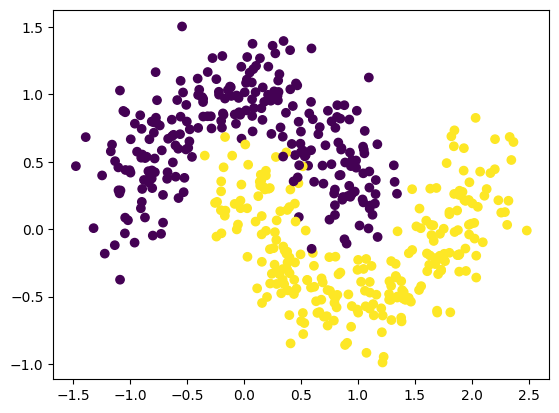

In [ ]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

_Tip:_ to plot classifiers decisions you colud use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ wirte function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

In [ ]:
def plot_decisions(clf, X, y):
    plot_decision_regions(X, y, clf=clf, legend=2)
    plt.title(clf.__class__.__name__)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from mlxtend.plotting import plot_decision_regions

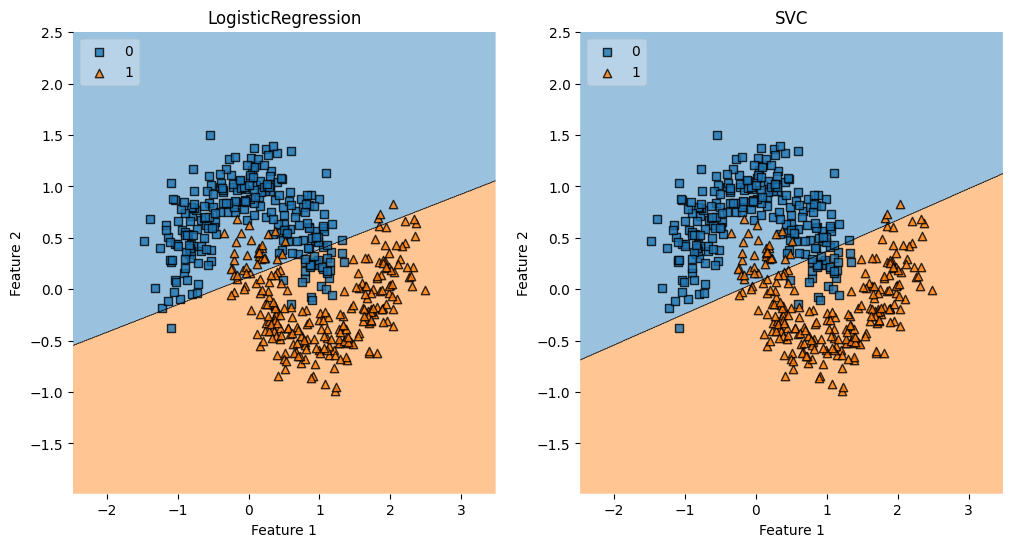

In [ ]:

lr = LogisticRegression(C=10, multi_class='multinomial', solver='saga', tol=1e-3)
lr.fit(moons_points, moons_labels)

svm = SVC(kernel='linear', C=10)
svm.fit(moons_points, moons_labels)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_decisions(lr, moons_points, moons_labels)

plt.subplot(1, 2, 2)
plot_decisions(svm, moons_points, moons_labels)

plt.show()

In [ ]:
from sklearn.metrics import f1_score


In [ ]:

lr_predictions  = lr.predict(moons_points)
svm_predictions = svm.predict(moons_points)

lr_f1  = f1_score(moons_labels, lr_predictions,  average='binary')
svm_f1 = f1_score(moons_labels, svm_predictions, average='binary')

print(f'F1 Score (Logistic Regression): {lr_f1:.2f}')
print(f'F1 Score (SVM): {svm_f1:.2f}')

F1 Score (Logistic Regression): 0.86
F1 Score (SVM): 0.86


Видим, что модели одинаково проводят гиперплоскость, f1 у них получилась одинаковой, 86% неплохой результат, однако гиперплоскость проведена слишком грубо (что и ожидалось от линейной модели), будем искать другой подход

## 1.2 Kernel tirck

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?
* How did decision border changed for each kernel?
* What `degree` have you chosen and why?

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:


def optimize_svm(kernel, param_grid):
    svm = SVC(kernel=kernel)
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(moons_points, moons_labels)


    return grid_search.best_estimator_


poly SVC(C=1, coef0=2, degree=7, kernel='poly')
rbf SVC(C=100, coef0=0, degree=1)
sigmoid SVC(C=0.1, coef0=1, degree=1, kernel='sigmoid')


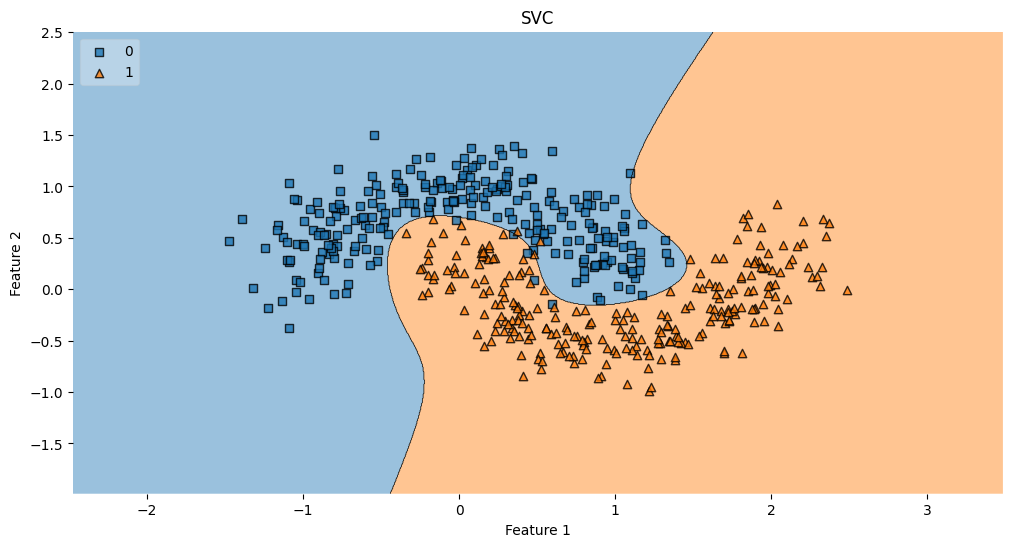

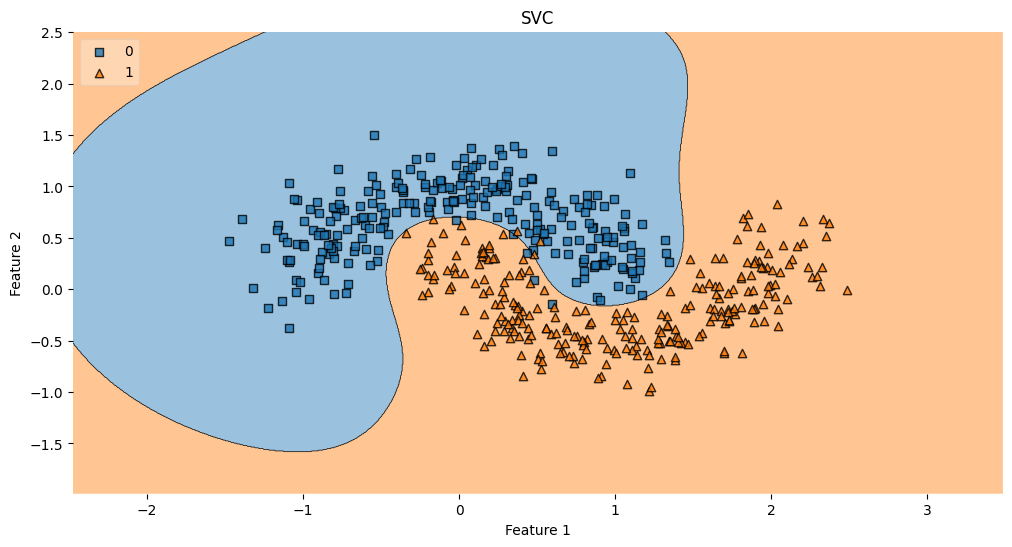

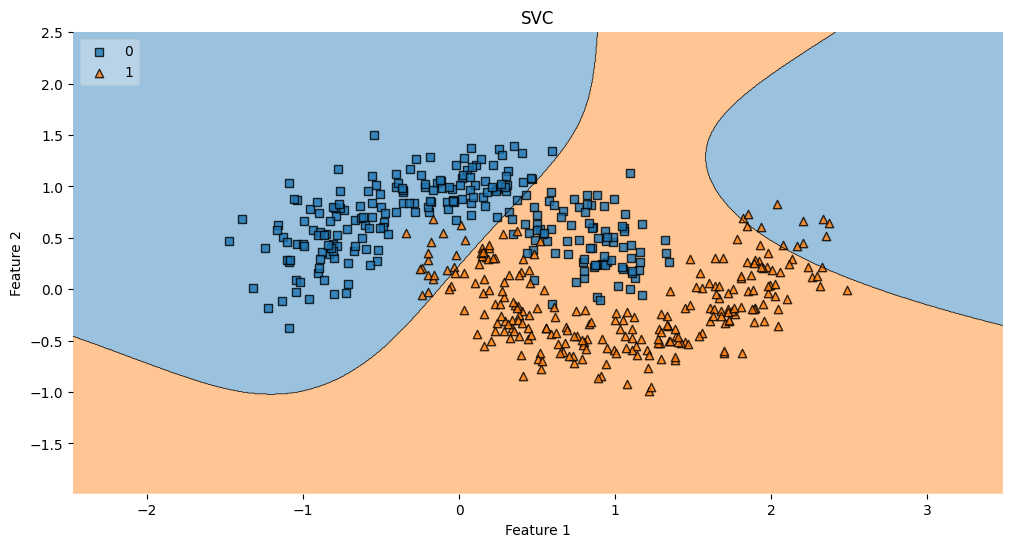

F1 Score (poly): 0.99
F1 Score (rbf): 0.98
F1 Score (sigmoid): 0.79


In [ ]:
kernels         = ['poly', 'rbf', 'sigmoid']
f1_scores       = []

for kernel in kernels:
    param_grid = {'C': [0.1, 1, 10, 100], 'degree': [1, 2, 3, 4, 5, 6, 7, 8], 'coef0': [0, 1, 2, 3, 4, 5, 6]}
    svm = optimize_svm(kernel, param_grid)

    print(kernel, svm)

    plt.figure(figsize=(12, 6))
    plot_decisions(svm, moons_points, moons_labels)

    svm_predictions = svm.predict(moons_points)
    svm_f1 = f1_score(moons_labels, svm_predictions, average='binary')

    f1_scores.append(svm_f1)

plt.show()

for kernel, f1 in zip(kernels, f1_scores):
    print(f'F1 Score ({kernel}): {f1:.2f}')


Видим, что качество классификации значительно выросло.Границы стали менее грубыми, например, у Poly ядра, меняя степень полинома гиперплоскости, удалось добиться хорошего результата в 0.99 f1 (degree =  7). rbf тоже хорошо справился с задачей, однако зачем-то замкнул в небольшую область объекты первого класса, что может привести к проблемам в дальнейшем. Sigmoid'а справилась чуть хуже.

## 1.3 Simpler solution (of a kind)
What is we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Comare SVM's results with this solution (quality, borders type)
* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

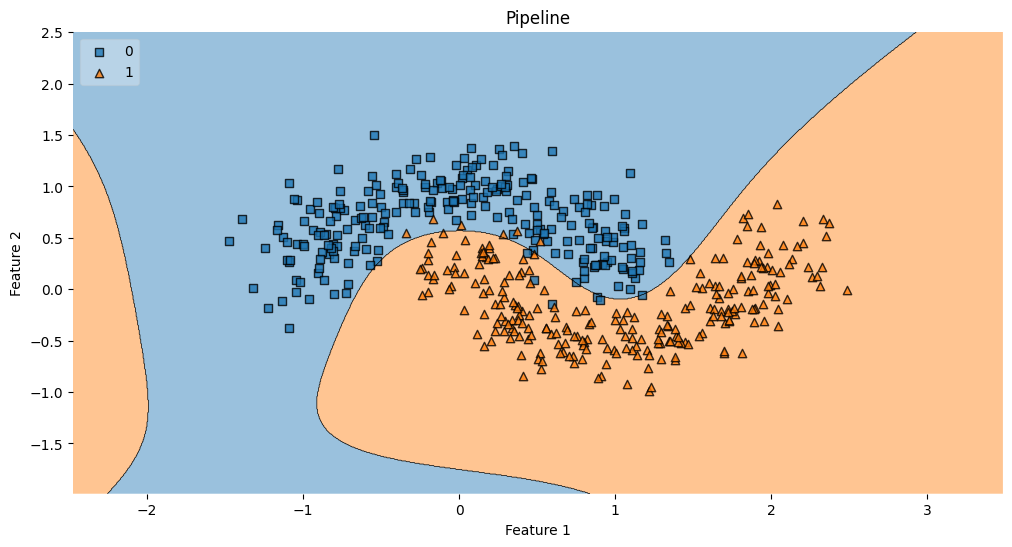

Pipeline(steps=[('poly', PolynomialFeatures(degree=6)),
                ('lr', LogisticRegression())])
F1 Score: 0.98


In [ ]:


### YOUR CODE HERE
param_grid = {
    'poly__degree': [1, 2, 3, 4, 5, 6, 7, 8]
}

poly = PolynomialFeatures()
lr   = LogisticRegression()

pipeline = Pipeline([
    ('poly', poly),
    ('lr', lr)
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(moons_points, moons_labels)

best_lr = grid_search.best_estimator_

plt.figure(figsize=(12, 6))
plot_decisions(best_lr, moons_points, moons_labels)

lr_predictions = best_lr.predict(moons_points)
lr_f1          = f1_score(moons_labels, lr_predictions, average='binary')

plt.show()

print(best_lr)
print(f'F1 Score: {lr_f1:.2f}')



Граница проведена достаточно хорошо, хотя конечно не очень понятна область слева. Качество определения упало на 1% - в рамках данной задачи думаю, что незначительно. Кросс-валидация показала, что оптимальное значение степени полинома = 6

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

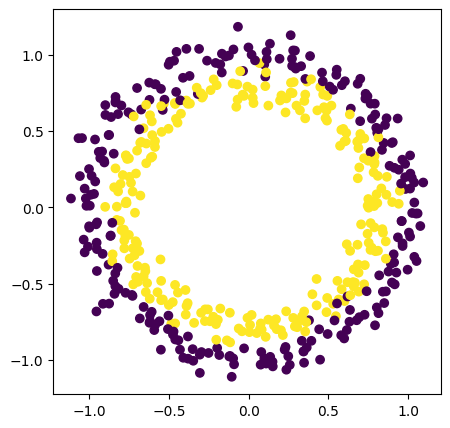

In [ ]:
from sklearn.datasets import make_circles

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(5, 5))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels)

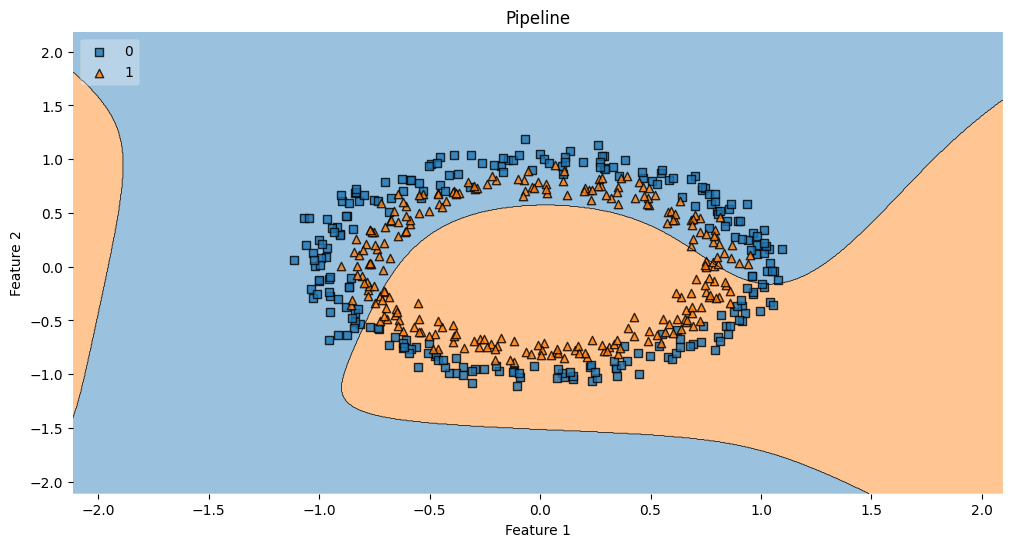

Pipeline(steps=[('poly', PolynomialFeatures(degree=10)),
                ('lr', LogisticRegression())])
F1 Score: 0.50


In [ ]:
param_grid = {
    'poly__degree': list(range(20))
}

poly = PolynomialFeatures()
lr   = LogisticRegression()

pipeline = Pipeline([
    ('poly', poly),
    ('lr', lr)
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(moons_points, moons_labels)

best_lr = grid_search.best_estimator_

plt.figure(figsize=(12, 6))
plot_decisions(best_lr, circles_points, circles_labels)

lr_predictions = best_lr.predict(circles_points)
lr_f1          = f1_score(circles_labels, lr_predictions, average='binary')

plt.show()

print(best_lr)
print(f'F1 Score: {lr_f1:.2f}')

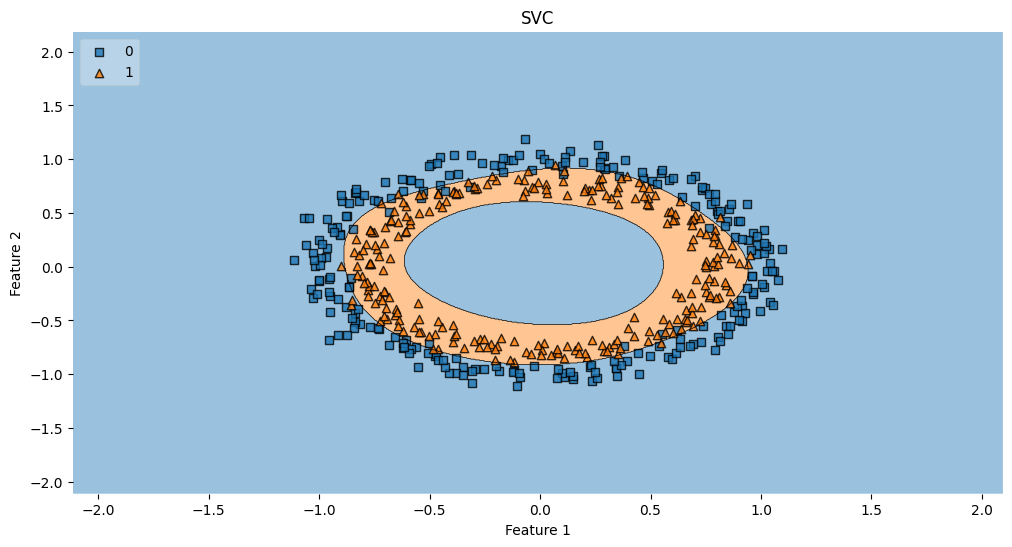

SVC(C=100, coef0=4, degree=5, kernel='poly')
F1 Score: 0.95


In [ ]:
param_grid = {'C': [10, 100, 500], 'kernel': ['poly', 'rbf', 'sigmoid'], 'degree': range(10), 'coef0': [2, 3, 4]}


svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(circles_points, circles_labels)

svm = grid_search.best_estimator_

plt.figure(figsize=(12, 6))
plot_decisions(svm, circles_points, circles_labels)

svm_predictions = svm.predict(circles_points)
svm_f1 = f1_score(circles_labels, svm_predictions, average='binary')

plt.show()

print(svm)
print(f'F1 Score: {svm_f1:.2f}')

Как видим, полиномиальное ядро степени 5 прекрасно справляется с проведением гиперплоскости и с хорошей точность разделяет объекты двух классов

And even more:

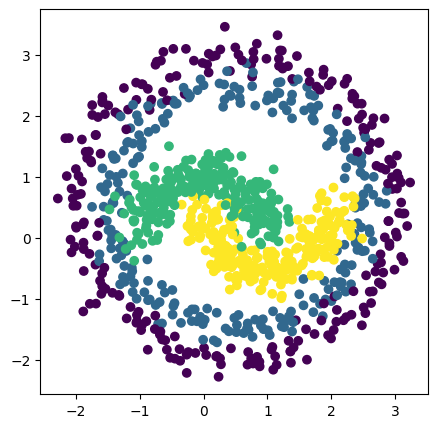

In [ ]:
points = np.vstack((circles_points*2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2)) # + 2 to distinct moons classes

plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], c=labels)

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


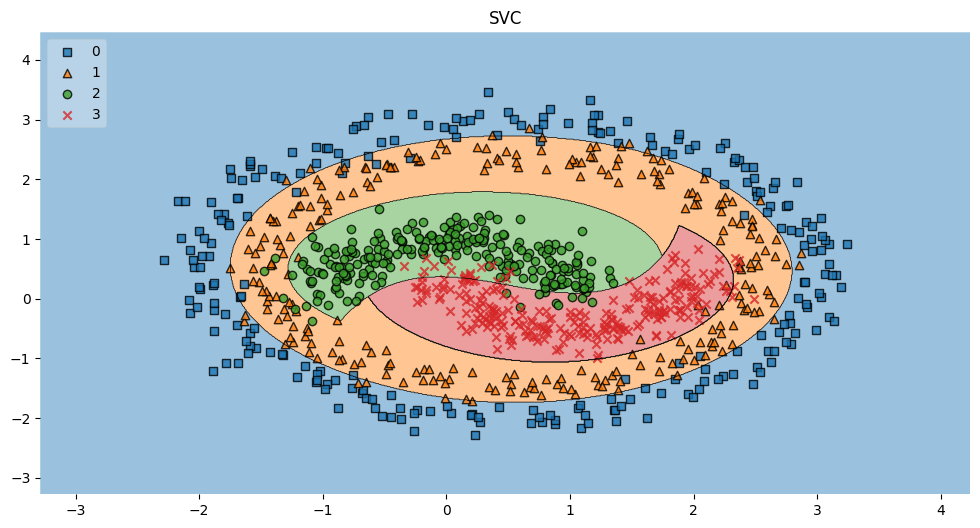

0.9209856718251709


In [ ]:
svm = SVC()
svm.fit(points, labels)
plt.figure(figsize=(12, 6))
plot_decisions(svm, points, labels)
plt.show()
print(f1_score(labels, svm.predict(points), average="macro"))


Хорошая точность для случайного выстрела, поэкспериментируем еще.

/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


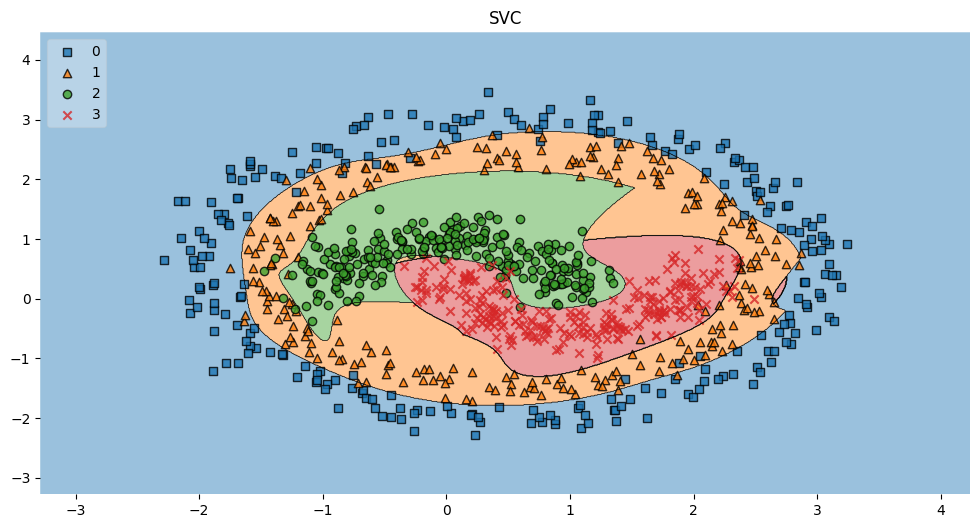

0.9459427530935082


In [ ]:
svm = SVC(kernel='poly', degree=7, coef0=4, C=100)
svm.fit(points, labels)
plt.figure(figsize=(12, 6))
plot_decisions(svm, points, labels)
plt.show()
print(f1_score(labels, svm.predict(points), average="macro"))

еще лучше)

/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


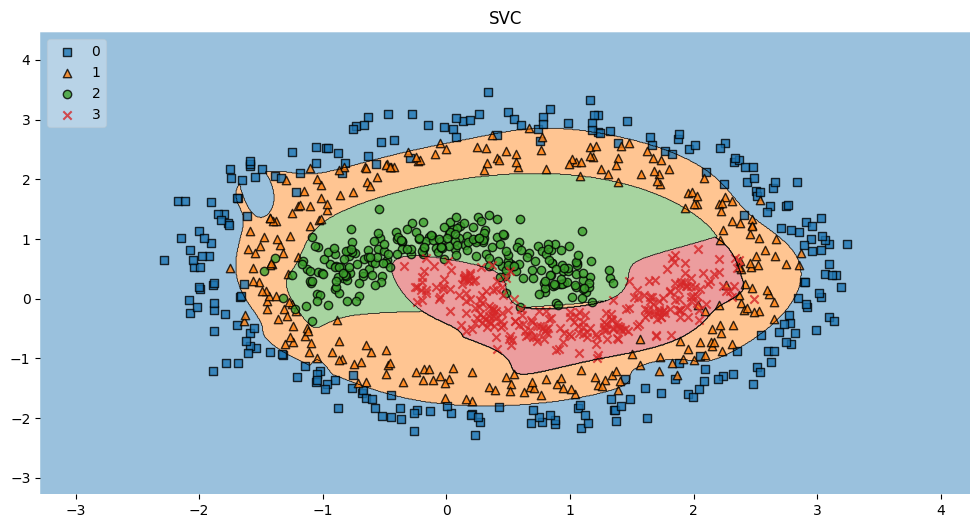

0.9461377711792452


In [ ]:
svm = SVC(kernel='poly', degree=8, coef0=4, C=100)
svm.fit(points, labels)
plt.figure(figsize=(12, 6))
plot_decisions(svm, points, labels)
plt.show()
print(f1_score(labels, svm.predict(points), average="macro"))

Теперь граница учла еще больше частных случаев. Попробуем еще увеличить степень полинома

/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


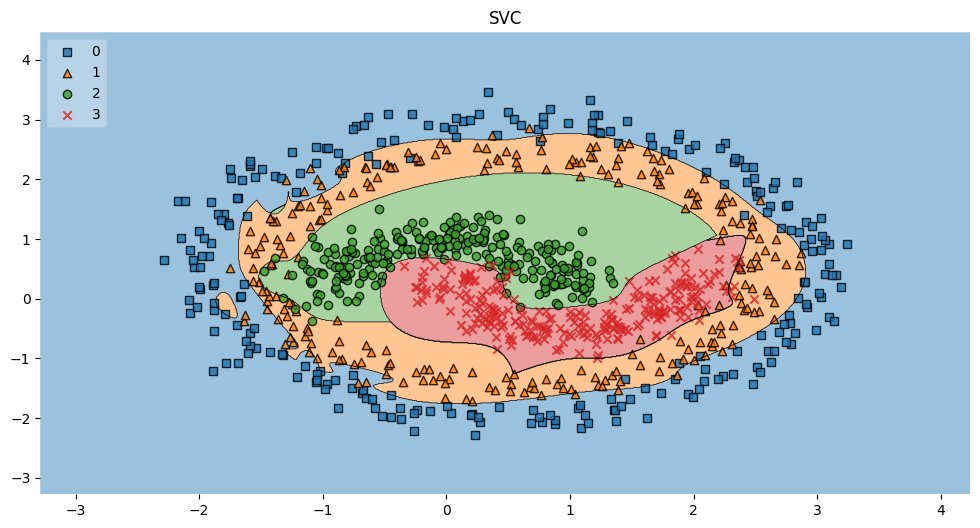

0.9337324080102456


In [ ]:
svm = SVC(kernel='poly', degree=9, coef0=4, C=100)
svm.fit(points, labels)
plt.figure(figsize=(12, 6))
plot_decisions(svm, points, labels)
plt.show()
print(f1_score(labels, svm.predict(points), average="macro"))

In [ ]:
Точнсть упала, так что будем считать результат, полученный на предыдущем шаге оптимальным. Границы проведены достаточно хорошо